### 한국어 TTS 최적화를 위한 필수 전처리 과정
1. 텍스트 정제, 자소분리, vocab 생성 및 tokenize
2. 음성 데이터 전처리
3. 멜스펙트로그램 변환

#### 참고 사항
- tacotron2와 waveglow 구현체에서는 아래 내용을 일부 포함하고 있습니다. 
- 한국어 TTS의 전반적인 이해를 도모하기 위해 간략하게 학습 데이터셋 생성 과정을 정리했습니다.

In [ ]:
!pip install librosa numpy noisereduce jamo webrtcvad matplotlib sentencepiece

### 1) 텍스트 전처리
- 정제
- 자소분리 (음소 단위 변환)
- vocab 생성

##### 텍스트 정제

In [2]:
import re

def normalize_numbers(text):
    """숫자를 한글 발음으로 변환"""
    num_dict = {
        "0": "영", "1": "일", "2": "이", "3": "삼", "4": "사",
        "5": "오", "6": "육", "7": "칠", "8": "팔", "9": "구"
    }
    return "".join(num_dict.get(c, c) for c in text)

def clean_text(text):
    """텍스트 정제"""
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'[^가-힣0-9\s,.!?]', '', text)  # 한글, 숫자, 공백, 구두점만 유지
    text = re.sub(r'\s+', ' ', text).strip()  # 연속된 공백 제거
    text = normalize_numbers(text)  # 숫자 변환
    return text

# 테스트
sample_text = "100cm짜리 2024년 모델입니다!"
print(clean_text(sample_text))  # "일공공 센티미터짜리 이공이사년 모델입니다!"


일영영짜리 이영이사년 모델입니다!


##### 자소 분리

In [3]:
import jamo

def split_jaso(text):
    """한글을 자소 단위로 분리"""
    return " ".join(jamo.hangul_to_jamo(text))

# 테스트
print(split_jaso("안녕하세요"))  # "ㅇㅏㄴ ㄴㅕㅇ ㅎㅏ ㅅㅔ ㅇㅛ"

ᄋ ᅡ ᆫ ᄂ ᅧ ᆼ ᄒ ᅡ ᄉ ᅦ ᄋ ᅭ


##### Tokenizer 및 Vocab 생성

In [8]:
import sentencepiece as spm

# 학습용 코퍼스 저장
corpus_texts = ["안녕하세요", "반갑습니다", "이 모델은 TTS 시스템입니다."]
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in corpus_texts:
        f.write(line + "\n")

# SentencePiece 모델 학습
spm.SentencePieceTrainer.train(input="corpus.txt", model_prefix="tokenizer", vocab_size=50, model_type="bpe")
# tokenizer.model 과 tokenizer.vocab이 생성됨.

# Tokenizer 불러오기
sp = spm.SentencePieceProcessor()
sp.load("tokenizer.model")

# 테스트
print(sp.encode_as_pieces("이 모델은 TTS 시스템입니다."))  # 예: ['▁이', '▁모델은', '▁TTS', '▁시스템입니다']

['▁이', '▁모델은', '▁TTS', '▁시스템입니다', '.']


### 2) 음성 데이터 전처리
- 샘플링 레이트 변환
- 무음 제거
- 볼륨 정규화
- 잡음 제거
- 데이터 길이 통일

##### 샘플링 레이트 변환 (16kHz -> 22.05kHz)

In [ ]:
import librosa
import soundfile as sf 

# 음성 데이터 로드
y, sr = librosa.load("Dataset/kss/1/1_0000.wav", sr=44010)

# 22050Hz로 변환
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=22050)

# soundfile을 사용하여 오디오 저장
sf.write("Dataset/example/resampled_audio.wav", y_resampled, 22050)

##### 무음 제거

In [15]:
import librosa
import soundfile as sf  

# 음성 데이터 로드
y, sr = librosa.load("Dataset/example/resampled_audio.wav", sr=22050)

# 무음 제거
y_trimmed, _ = librosa.effects.trim(y, top_db=20)

sf.write("Dataset/example/trimmed_audio.wav", y_trimmed, sr)


##### 볼륨 정규화

In [16]:
import numpy as np
import soundfile as sf  

def normalize_audio(y):
    return y / np.max(np.abs(y))  # 최대 진폭을 1로 정규화

y, sr = librosa.load("Dataset/example/trimmed_audio.wav", sr=22050)
y_norm = normalize_audio(y)

sf.write("Dataset/example/normalized_audio.wav", y_norm, sr)


##### 잡음 제거

In [ ]:
import librosa
import noisereduce as nr
import soundfile as sf

# 음성 데이터 로드
y, sr = librosa.load("Dataset/example/normalized_audio.wav", sr=22050)

# 노이즈 프로파일 추출 (초반 1초를 노이즈로 가정)
noisy_part = y[:sr]  

# 잡음 제거 적용
y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noisy_part, prop_decrease=0.8)

sf.write("Dataset/example/denoised_audio.wav", y_denoised, sr)


### 3) 멜 스펙트로그램 생성 및 시각화
- 멜 스펙트로그램 변환
- 멜 스펙트로그램 시각화

##### 멜 스펙트로그램 변환

In [23]:
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load("Dataset/example/denoised_audio.wav", sr=22050)

# 멜스펙트로그램 변환
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, hop_length=256, win_length=1024, fmax=8000)

# 로그 변환
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

##### 멜 스펙트로그램 시각화

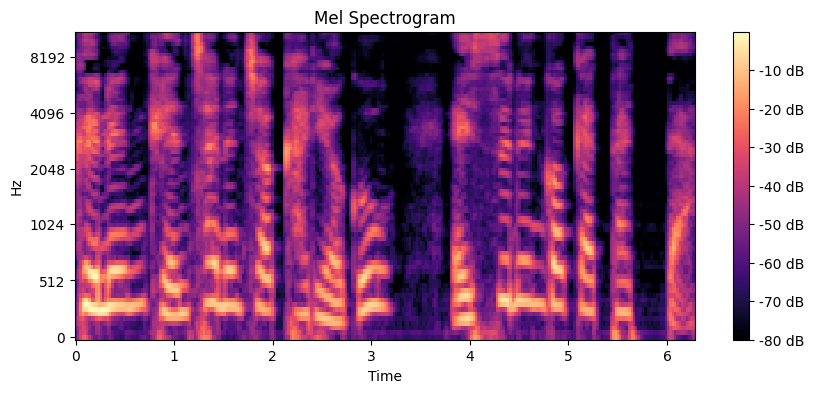

In [24]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

### 🔍 정리: 전체 전처리 프로세스

##### ✅ 텍스트 전처리
- 텍스트 정제 (clean_text())
- 자소 분리 (split_jaso())
- 토크나이저 (sentencepiece 활용)

##### ✅ 음성 데이터 전처리
- 샘플링 레이트 통일 (16kHz → 22.05kHz)
- 무음 제거 (librosa.effects.trim())
- 볼륨 정규화
- 잡음 제거 (noisereduce 활용)

##### ✅ 멜스펙트로그램 변환 및 시각화
- 80개 Mel 필터 사용
- Hop length 256, Win length 1024
- fmax=8000 설정
- 로그 스펙트로그램 변환 후 시각화

---

## **Tacotron2 학습 데이터셋 생성**
Tacotron2의 입력(X)과 출력(Y)을 구성하여 학습 데이터셋을 만듭니다.

- **입력(X):** 텍스트 (음소 변환된 문장)
- **출력(Y):** Mel-Spectrogram (STFT를 통해 변환한 오디오 데이터)
- **저장 파일:** `tacotron2_train.npy`


### 사용할 텍스트 전처리 함수

In [28]:
import re
import sentencepiece as spm
from tacotron2.layers import TacotronSTFT

# ✅ SentencePiece 모델 로드
SP_MODEL_PATH = "./tokenizer.model"
sp = spm.SentencePieceProcessor()
sp.load(SP_MODEL_PATH)

# ✅ Tacotron2 STFT 설정
stft = TacotronSTFT()

# ✅ 1. 텍스트 정제 함수
def clean_text(text):
    """ 한글 외 문자 제거 및 정제 """
    text = re.sub(r"[^가-힣0-9\s]", "", text)  # 한글, 숫자, 공백만 남기기
    text = re.sub(r"\s+", " ", text).strip()  # 연속된 공백 제거
    return text

# ✅ 2. 자소 분리 함수
def split_jaso(text):
    """ 한글을 초성/중성/종성으로 분리 """
    CHOSUNG_LIST  = "ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ"
    JUNGSUNG_LIST = "ㅏㅐㅑㅒㅓㅔㅕㅖㅗㅘㅙㅚㅛㅜㅝㅞㅟㅠㅡㅢㅣ"
    JONGSUNG_LIST = " ㄱㄲㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅆㅇㅈㅊㅋㅌㅍㅎ"

    result = []
    for char in text:
        code = ord(char) - ord("가")
        if 0 <= code <= 11171:  # 한글 음절인지 확인
            cho = CHOSUNG_LIST[(code // 588) % 19]
            jung = JUNGSUNG_LIST[(code // 28) % 21]
            jong = JONGSUNG_LIST[code % 28]
            if jong == " ":
                result.extend([cho, jung])
            else:
                result.extend([cho, jung, jong])
        else:
            result.append(char)
    return "".join(result)

# ✅ 3. SentencePiece 토크나이저 적용 함수
def tokenize(text):
    return sp.encode_as_pieces(text)

# ✅ 4. 스페셜 토큰 적용 함수
def apply_special_tokens(tokens):
    return ["<sos>"] + tokens + ["<eos>"]

# ✅ 5. 전체 텍스트 전처리 함수
def preprocess_text(text):
    text = clean_text(text)
    text = split_jaso(text)
    tokens = tokenize(text)
    tokens = apply_special_tokens(tokens)
    return tokens


### 사용할 오디오 전처리 함수

In [29]:
### 사용할 오디오 전처리 함수
import librosa
import numpy as np
import noisereduce as nr

# ✅ 1. 샘플링 레이트 변환 함수 (16kHz → 22.05kHz)
def resample_audio(y, orig_sr, target_sr=22050):
    """ 오디오 샘플링 레이트를 22.05kHz로 변환 """
    if orig_sr != target_sr:
        y = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)
    return y, target_sr

# ✅ 2. 무음 제거 함수
def remove_silence(y, top_db=20):
    """ librosa의 trim()을 사용해 앞뒤 무음을 제거 """
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

# ✅ 3. 볼륨 정규화 함수
def normalize_volume(y, target_dB=-20.0):
    """ RMS 기반 볼륨 정규화 (target_dB 값으로 설정) """
    rms = np.sqrt(np.mean(y**2))  # RMS 계산
    scalar = 10 ** (target_dB / 20) / rms  # 볼륨 스케일링 값 계산
    y_normalized = y * scalar
    return np.clip(y_normalized, -1.0, 1.0)  # 값 범위를 -1 ~ 1로 제한

# ✅ 4. 잡음 제거 함수
def denoise_audio(y, sr):
    """ noisereduce를 사용해 오디오 잡음 제거 """
    y_denoised = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.8)
    return y_denoised


### Tacotron2 학습 데이터셋 생성 코드

In [58]:
import os
import torch
import librosa
import numpy as np
import noisereduce as nr
from tacotron2.layers import TacotronSTFT

# ✅ Tacotron2 STFT 설정
stft = TacotronSTFT()

# ✅ 데이터셋 경로 설정
audio_dir = "Dataset/kss/1"  # WAV 파일 폴더
text_path = "Dataset/transcript.v.1.4.txt"  # 텍스트 데이터

# ✅ 텍스트 로드 & 전처리 적용
text_dict = {}

with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("|")
        if len(parts) < 2:
            continue
        file_id, text = parts[0], parts[1]
        
        # file_id가 "1/"인 line까지만 데이터 처리
        if  file_id.startswith("2/"):
            break  
        
        text_dict[file_id] = preprocess_text(text)  # ✅ 텍스트 전처리 적용
        
print("✅ 텍스트 로드 완료:", list(text_dict.keys())[:5])  # 첫 5개 확인

# ✅ Mel-Spectrogram 데이터 생성
tacotron2_train_data = []

for file_name in os.listdir(audio_dir):
    if not file_name.endswith(".wav"):
        continue

    # ✅ "1/" 추가하여 `text_dict` 키와 일치시키기
    file_id_with_dir = f"1/{os.path.splitext(file_name)[0]}"

    print(f"Checking file_id: {file_id_with_dir}, Exists in text_dict: {file_id_with_dir in text_dict}")

    if file_id_with_dir not in text_dict:
        continue  # 텍스트 데이터가 없으면 스킵

    # ✅ 오디오 파일 경로 생성 및 파일 존재 여부 확인
    wav_path = os.path.join(audio_dir, file_name)
    if not os.path.isfile(wav_path):
        print(f"🚨 파일이 존재하지 않음: {wav_path}")
        continue
    y, sr = librosa.load(wav_path, sr=None)  # 원본 SR 유지

    # ✅ 오디오 전처리 적용
    y, sr = resample_audio(y, sr, 22050)  # 샘플링 레이트 변환
    y = remove_silence(y)  # 무음 제거
    y = normalize_volume(y)  # 볼륨 정규화
    y = denoise_audio(y, sr)  # 잡음 제거

    # ✅ Mel-Spectrogram 변환
    mel_spectrogram = stft.mel_spectrogram(torch.tensor(y).unsqueeze(0))

    # ✅ 데이터 저장 (전처리된 텍스트 + Mel-Spectrogram)
    tacotron2_train_data.append((text_dict[file_id], mel_spectrogram.squeeze().numpy()))

# ✅ NumPy 파일로 저장
np.save("Dataset/example/tacotron2_train.npy", tacotron2_train_data)


print(f"Tacotron2 학습 데이터셋 생성 완료! ({len(tacotron2_train_data)}개 샘플 저장됨)")

✅ 텍스트 로드 완료: ['1/1_0000.wav', '1/1_0001.wav', '1/1_0002.wav', '1/1_0003.wav', '1/1_0004.wav']
Checking file_id: 1/1_0000, Exists in text_dict: False
Checking file_id: 1/1_0001, Exists in text_dict: False
Checking file_id: 1/1_0002, Exists in text_dict: False
Checking file_id: 1/1_0003, Exists in text_dict: False
Checking file_id: 1/1_0004, Exists in text_dict: False
Checking file_id: 1/1_0005, Exists in text_dict: False
Checking file_id: 1/1_0006, Exists in text_dict: False
Checking file_id: 1/1_0007, Exists in text_dict: False
Checking file_id: 1/1_0008, Exists in text_dict: False
Checking file_id: 1/1_0009, Exists in text_dict: False
Checking file_id: 1/1_0010, Exists in text_dict: False
Checking file_id: 1/1_0011, Exists in text_dict: False
Checking file_id: 1/1_0012, Exists in text_dict: False
Checking file_id: 1/1_0013, Exists in text_dict: False
Checking file_id: 1/1_0014, Exists in text_dict: False
Checking file_id: 1/1_0015, Exists in text_dict: False
Checking file_id: 1/1_0016


## **WaveGlow 학습 데이터셋 생성**
WaveGlow의 입력(X)과 출력(Y)을 구성하여 학습 데이터셋을 만듭니다.

- **입력(X):** Mel-Spectrogram (Tacotron2 출력)
- **출력(Y):** 원래 Waveform (오디오 데이터)
- **저장 파일:** `waveglow_train.npy`


In [ ]:
import os
import torch
import librosa
import numpy as np
from tacotron2.layers import TacotronSTFT

# ✅ Tacotron2 STFT 설정
stft = TacotronSTFT()

# ✅ 데이터셋 경로 설정
audio_dir = "Dataset/kss/1"  # WAV 파일 폴더
output_path = "waveglow_train.npy"  # 학습 데이터 저장 파일

# ✅ Mel-Spectrogram과 Waveform 쌍을 저장할 리스트
waveglow_train_data = []

for file_name in os.listdir(audio_dir):
    if not file_name.endswith(".wav"):
        continue

    # ✅ 파일명에서 확장자 제거 후 "1/" 추가
    file_id_with_dir = f"1/{os.path.splitext(file_name)[0]}"

    # ✅ 오디오 파일 경로 생성 및 존재 여부 확인
    wav_path = os.path.join(audio_dir, file_name)
    if not os.path.isfile(wav_path):
        print(f"🚨 파일이 존재하지 않음: {wav_path}")
        continue

    # ✅ 오디오 파일 로드
    y, sr = librosa.load(wav_path, sr=None)  # 원본 SR 유지

    # ✅ 오디오 전처리 적용
    y, sr = resample_audio(y, sr, 22050)  # 샘플링 레이트 변환
    y = remove_silence(y)  # 무음 제거
    y = normalize_volume(y)  # 볼륨 정규화
    y = denoise_audio(y, sr)  # 잡음 제거

    # ✅ Mel-Spectrogram 변환
    mel_spectrogram = stft.mel_spectrogram(torch.tensor(y).unsqueeze(0))

    # ✅ 데이터 저장 (Mel-Spectrogram, Waveform)
    waveglow_train_data.append((mel_spectrogram.squeeze().numpy(), y))

# ✅ NumPy 파일로 저장
np.save(output_path, waveglow_train_data)

print(f"✅ WaveGlow 학습 데이터셋 생성 완료! ({len(waveglow_train_data)}개 샘플 저장됨)")
